# Initial Setup

In [120]:
import pandas as pd
import os
import numpy as np
import datetime
from plotnine import *
import matplotlib.pyplot as plt
from model_diagnostics import model_diagnostics, skf_preds, model_diagnostics_skf, summarise_continuous_feature

#pd.set_option("display.max_rows", 20)

In [121]:
filename = os.getcwd() + "/train.csv"
data = pd.read_csv(filename)

In [122]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Extract deck feature, do some EDA

In [123]:
data['Deck'] = data['Cabin'].str[0]
#data.loc[data['Cabin'].isnull(), 'Deck'] = 'M'
data['Deck'] = data['Deck'].fillna('M')
data['CabinNo'] = data['Cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int)

# Maggie's feedback
# XGBoost doesn't really care about missing value imputation
# Good to build the skillset
# You have so many features in trust, you don't have the time to impute all of them

# Look at Kaggle winner features
# In work - you have time constraints -> you want to ship something, even if feature engineering is not perfect
# Pick another dataset, instead and go through the whole workflow
# Another thing that could be worth doing -- basic plot for feature importance, can help you debug. You can focus on important features etc

# When choosing encoding strategy? When you have a lot of features, you don't care. With few features, you can do something clever.
# Pearson's correlation between your encoded feature and survival -- does it drop or not? Good for not intuitive features. Pearson when capping things
# Could also look at R^2 of regression, or create both features and trying the whole model with both. Don't want to do this for everything. 
# Ordinal vs one hot encoding for deck -- how differentiated you are among groups.
# Manually looking through correlations -- intuitive enough
# It often becomes a time tradeoff.
# Most important part of feature engineering is getting enough info. Priority is getting enough features, less important is encoding / grouping etc.

In [124]:
survival_deck = (
    data
    .groupby('Deck')
    .agg(n = ('SibSp', 'count'),
         pct_survived = ('Survived', 'mean'))
    .reset_index()
)

survival_deck

,Deck,n,pct_survived
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,M,687,0.299854
8,T,1,0.000000


In [125]:
#df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
data['Deck'] = data['Deck'].replace(['A', 'T'], 'A')
data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')
data['Deck'].value_counts()

M     687
C      59
B      47
D      33
E      32
FG     17
A      16
Name: Deck, dtype: int64

In [126]:
# Different encoding for deck
# data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
# data['Deck'] = data['Deck'].replace(['A', 'B', 'C'], 'ABC')
# data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')

# data['Deck'].value_counts()

In [127]:
survival_cabno = (
    data[data['CabinNo'] > 0]
    .assign(cabno_quantile = lambda x: pd.qcut(x['CabinNo'], 10))
    .groupby('cabno_quantile')
    .agg(n = ('Ticket', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

survival_cabno

,cabno_quantile,n,avg_survival
0,"(1.999, 7.0]",21,0.666667
1,"(7.0, 19.8]",19,0.789474
2,"(19.8, 25.0]",21,0.714286
3,"(25.0, 33.0]",20,0.650000
4,"(33.0, 43.0]",19,0.736842
5,"(43.0, 51.0]",21,0.619048
6,"(51.0, 68.3]",19,0.631579
7,"(68.3, 85.2]",20,0.600000
8,"(85.2, 101.0]",21,0.714286
9,"(101.0, 148.0]",19,0.578947


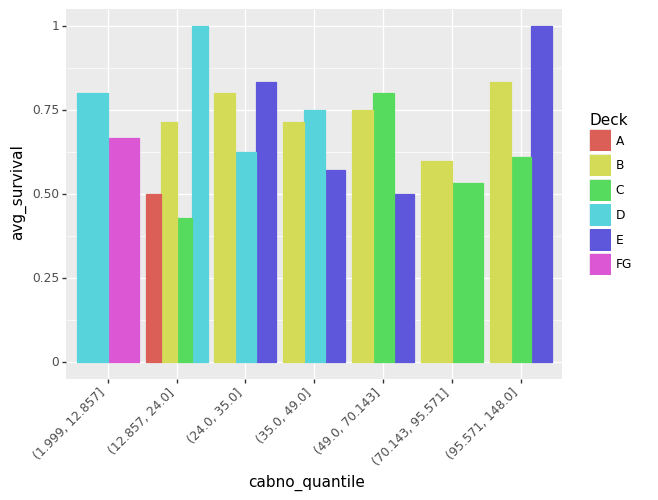

<ggplot: (8772773144709)>

In [128]:
survival_cabno_deck = (
    data[data['CabinNo'] > 0]
    .assign(cabno_quantile = lambda x: pd.qcut(x['CabinNo'], 7 ))
    .groupby(['cabno_quantile', 'Deck'])
    .agg(n = ('Ticket', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

(
    ggplot(survival_cabno_deck[survival_cabno_deck.n > 4])
    + aes(x = 'cabno_quantile', y = 'avg_survival', color = 'Deck', fill = 'Deck')
    + geom_bar(stat = 'identity', position = 'dodge')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Train a model including deck and cabin number

In [129]:
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        #print(X.shape)
        self.shape = X.shape
        self.X = X
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
class TestImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, grouping_cols):
        self.target_col = target_col
        self.grouping_cols = grouping_cols

    def fit(self, X, y = None):
        self.group_medians = X.groupby(self.grouping_cols).agg(median = (self.target_col, 'median')).reset_index()
        print(self.group_medians)
        return self

    def transform(self, X, y = None):
        df_return = X.merge(self.group_medians, on = self.grouping_cols)
        #df_return.loc[df_return[self.target_col].isna(), self.target_col] = df_return['median']
        return df_return

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.toarray()
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X.loc[:, self.feature_names].copy(deep = True)


In [130]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['SibSp', 'Parch', 'CabinNo', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2]),
                    ('disc_cabno', StandardScaler(), [-3])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2, -3])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_disc),
    ('debug', Debug()),
    ('clf', xgb_model),
])

cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

In [131]:
df_scores_agg

accuracy             0.815893
average_precision    0.838945
f1_score             0.749356
auc                  0.858845
dtype: float64

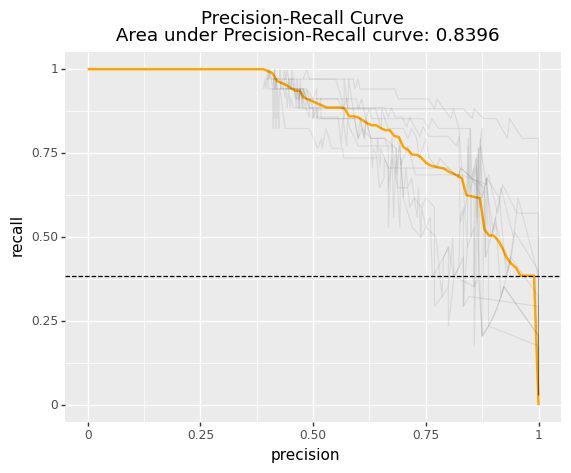

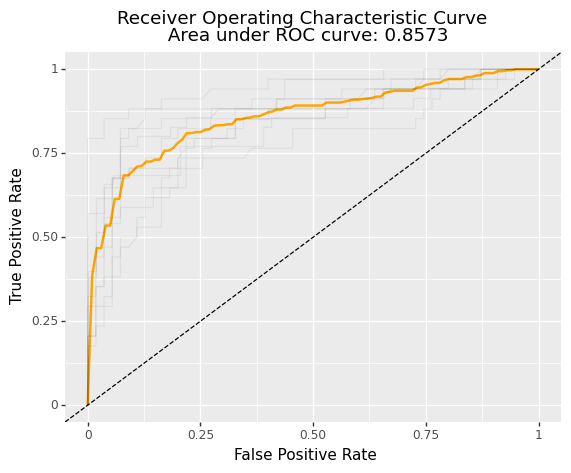

[<ggplot: (8772773415831)>, <ggplot: (8772790900682)>]

In [132]:
plots_list

# Extract title feature

In [133]:
data['Title'] = data['Name'].str.split(",", expand = True)[1].str.split('.', expand = True)[0].str.strip()

In [134]:
data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [135]:
survival_title = (
    data
    .groupby('Title')
    .agg(n = ('Name', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

survival_title

,Title,n,avg_survival
0,Capt,1,0.000000
1,Col,2,0.500000
2,Don,1,0.000000
3,Dr,7,0.428571
4,Jonkheer,1,0.000000
5,Lady,1,1.000000
6,Major,2,0.500000
7,Master,40,0.575000
8,Miss,182,0.697802
9,Mlle,2,1.000000


In [136]:
data.query('Name.str.contains("Mme")', engine = "python")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,CabinNo,Title
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3,B35,C,B,35,Mme


In [137]:
data['Title'] = data['Title'].replace(['Ms'], 'Miss')

noble_list = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
#noble_list = ['Mlle', 'the Countess', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
#military_clergy_list = ['Rev', 'Major', 'Col', 'Capt']

data['Title'] = data['Title'].replace(noble_list, 'Noble')
#data['Title'] = data['Title'].replace(military_clergy_list, 'Military_Clergy')
#data['Title'] = data['Title'].replace('Dr', 'Mr')

data['Title'].value_counts()

Mr        517
Miss      183
Mrs       125
Master     40
Noble      26
Name: Title, dtype: int64

In [138]:
data['Married'] = 0
data.loc[data['Title'] == 'Mrs', 'Married'] = 1

In [139]:
survival_title = (
    data
    .groupby('Title')
    .agg(n = ('Name', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

survival_title

,Title,n,avg_survival
0,Master,40,0.575000
1,Miss,183,0.699454
2,Mr,517,0.156673
3,Mrs,125,0.792000
4,Noble,26,0.423077


# Train a model using Title and Married features

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['SibSp', 'Parch', 'CabinNo', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2]),
                    ('disc_cabno', StandardScaler(), [-3])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_disc),
    ('clf', xgb_model),
])

cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

# Maggie feedback
# Fine tune parameters -- hyperparameters are a big part of XGBoost's power. 
# Eg. eta, learning rate, max_depth, min_child_weight, lambda / alpha (reguraization), colsample_bytree, subsample (row/column sampling), max_leaves
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
# gridsearch / randomsearch (quicker) / bayessearch (takes a long time, most scientific) -> hyperparemeters are good, but not life-changing 
# In production, you keep hyperparameters for ~1/2 a year until you retrain
# Evaluation - unbalanced data (accuracy is bad). Precision / recall, F1 / F2

# When training - don't really need to look at the graph, just the scores are ok
# Overfitting - cross validation: train vs val metric differences (the metrics you already have). 
# Not enough data -> just use validation from training set
# When you can -> get a different validation set
# Look at different

# No need to plot every time you add a feature etc.
# Plotting is something you can do at the beginning/end -- when you're looking at threshold / hyperparameters


In [141]:
df_scores_agg

accuracy             0.821511
average_precision    0.842128
f1_score             0.756889
auc                  0.862321
dtype: float64

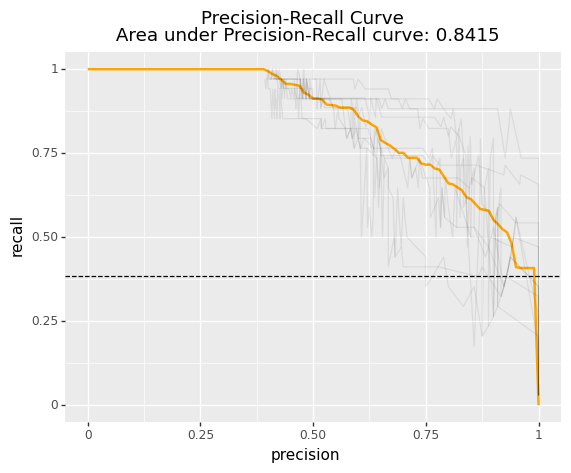

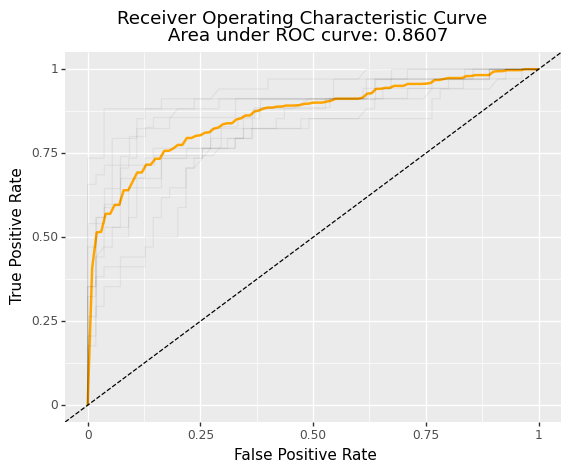

[<ggplot: (8772773266390)>, <ggplot: (8772773162177)>]

In [142]:
plots_list

# Look at Family Size Varible combining Parch and Sibsp

In [143]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [144]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['FamilySize', 'CabinNo', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230303)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2]),
                    ('disc_cabno', StandardScaler(), [-3])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_disc),
    ('clf', xgb_model),
])

cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)


In [145]:
df_scores_agg

accuracy             0.821498
average_precision    0.842377
f1_score             0.762803
auc                  0.866181
dtype: float64

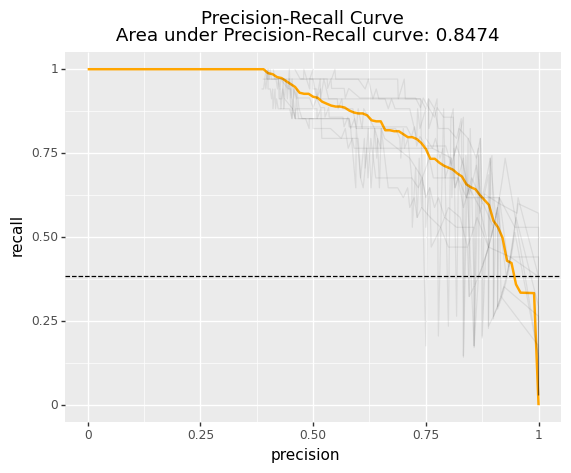

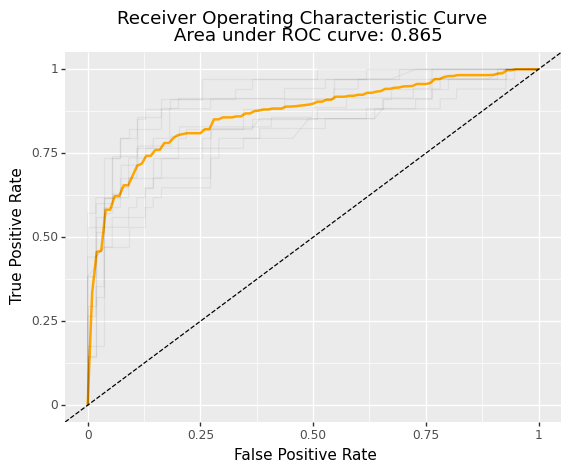

[<ggplot: (8772772742834)>, <ggplot: (8772772742735)>]

In [146]:
plots_list

# Does a different imputation strategy work better?

In [178]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
#from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
import xgboost as xgb
from sklearn import set_config
from sklearn.neural_network import MLPClassifier
set_config(display='diagram')

target = 'Survived'
numeric_cols = ['FamilySize', 'CabinNo', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230303)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)

categorical_pipeline = Pipeline(steps = [
    ("selector", FeatureSelector(categorical_cols)),
    ("encoder", OneHotEncoder(handle_unknown='ignore')),
])

numerical_pipeline = Pipeline(steps = [
    ('selector', FeatureSelector(numeric_cols)),
    ('scaler', StandardScaler()),
])

feature_pipeline = FeatureUnion(
    transformer_list = [
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ]
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)
mlpc = MLPClassifier(hidden_layer_sizes = (11, 11, 11), max_iter = 500)

model_pipeline = Pipeline(
    steps = [
    ("feature_pipeline", feature_pipeline),
    ('to_dense', DenseTransformer()),
    ('imputer', IterativeImputer()),                               
    ("model", xgb_model)
#    ('model', mlpc)
    ]
)

cv_results = cross_validate(model_pipeline, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

In [179]:
df_scores_agg

accuracy             0.827116
average_precision    0.847410
f1_score             0.769760
auc                  0.874076
dtype: float64

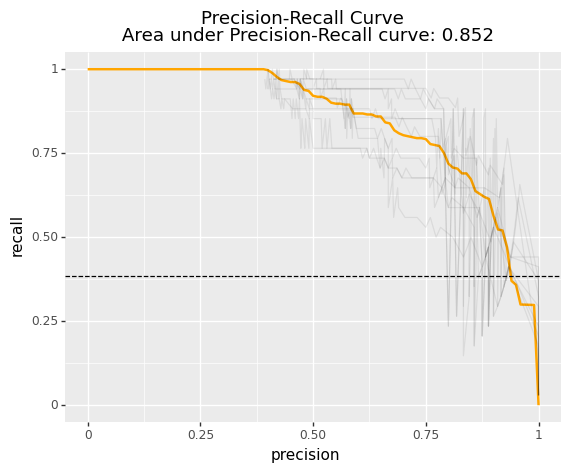

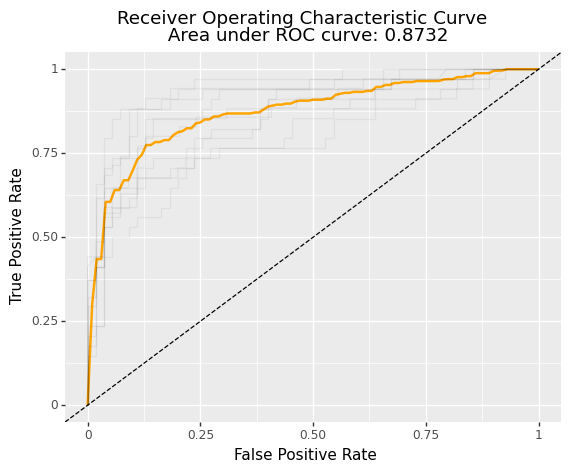

[<ggplot: (8772791415293)>, <ggplot: (8772714361272)>]

In [180]:
plots_list

# Train a logistic regression to see what features even matter

In [150]:
pipe.fit(X, y)
X_final = pipe.named_steps['debug'].X

X_final[1, :]

KeyError: 'debug'

# Feature importance plot

In [162]:
model_pipeline = Pipeline(
    steps = [
    ("feature_pipeline", feature_pipeline),
    ('to_dense', DenseTransformer()),
    ('imputer', IterativeImputer())
])

a = model_pipeline.fit_transform(X, y)
a.shape

(891, 25)

In [154]:
model_pipeline.fit(X, y)
model = model_pipeline['model']
model.feature_importances_

array([0.04006749, 0.02348221, 0.01791185, 0.01553658, 0.00980967,
       0.03218696, 0.07941837, 0.01971052, 0.        , 0.01661424,
       0.03305391, 0.01209767, 0.        , 0.00527617, 0.00727623,
       0.01582174, 0.02172902, 0.01677412, 0.        , 0.00654349,
       0.00664906, 0.02338972, 0.48918957, 0.00662027, 0.10084103],
      dtype=float32)

In [152]:
model.feature_names_in_

AttributeError: 'XGBClassifier' object has no attribute 'feature_names_in_'

# Code for accessing feature names

In [167]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({'brand': ['aaaa', 'asdfasdf', 'sadfds', 'NaN'],
                   'category': ['asdf', 'asfa', 'asdfas', 'as'],
                   'num1': [1, 1, 0, 0],
                   'target': [0.2, 0.11, 1.34, 1.123]})

numeric_features = ['num1']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['brand', 'category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  LinearRegression())])
clf.fit(df.drop('target', axis = 1), df['target'])

clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names_out(categorical_features)

# ['brand_NaN' 'brand_aaaa' 'brand_asdfasdf' 'brand_sadfds' 'category_as'
#  'category_asdf' 'category_asdfas' 'category_asfa']

array(['brand_NaN', 'brand_aaaa', 'brand_asdfasdf', 'brand_sadfds',
       'category_as', 'category_asdf', 'category_asdfas', 'category_asfa'],
      dtype=object)

In [172]:
clf[:-1].get_feature_names_out()

AttributeError: Estimator imputer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?